In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import cv2

## Open the image and displays it

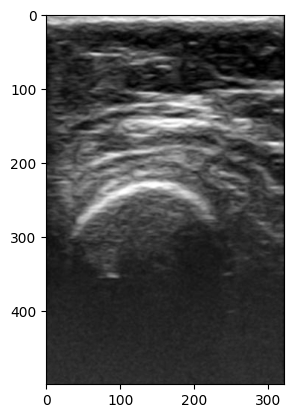

In [2]:
img = cv2.imread("../../Data/Images_set/3DUS_L_probe1_conf1_ds1.dcm_p296.jpg", 0)
# img = cv2.imread("example.png", 0)
plt.imshow(img, cmap='gray')

## Apply a Gaussian filter

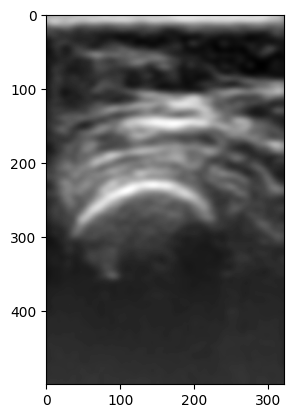

In [3]:
ksize = 25
blur = cv2.GaussianBlur(img,(ksize,ksize),0)
plt.imshow(blur, cmap='gray')

## Apply a threshold on the blurred image

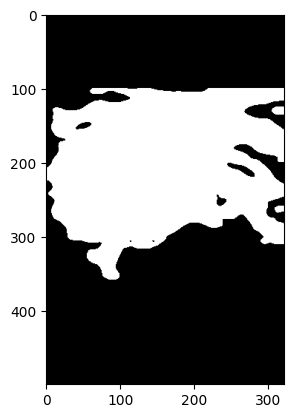

In [4]:
threshold = 0.2
ret,thresh = cv2.threshold(blur,round(threshold*255),1,cv2.THRESH_BINARY)

# Remove the top layer
proportion = 0.2
height = round(proportion * img.shape[0])
thresh[:height] = 0

plt.imshow(thresh, cmap='gray')

## Apply a Laplacian of Gaussian (LoG)

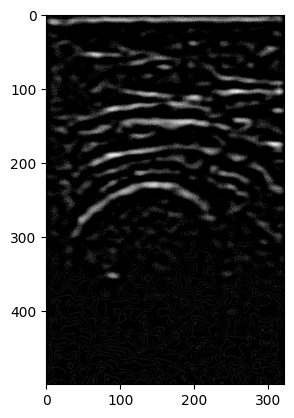

In [5]:
laplacian = cv2.Laplacian(blur, ddepth=cv2.CV_16S, ksize=5)

# Only keep the negative pixels
laplacian = -laplacian
laplacian = laplacian / np.max(laplacian)
laplacian = np.clip(laplacian, 0, 1)

plt.imshow(laplacian, cmap='gray')

## Shadow model

$\operatorname{Shadow}(a, b)=\frac{\sum_{j=a}^R G(j-a) I(j, b)}{\sum_{j=a}^R G(j-a)}$

In [6]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

def shadow_value(img, mu=0, sigma=40):
    shadow_img = np.zeros(img.shape)
    R, C = img.shape
    G = np.tile(gaussian(np.arange(R), mu, sigma), (C, 1)).T
    for a in range(R):
        I = img[a:]
        # Compute the numerator and denominator of the shadow formula
        numerator = np.sum(G[:R-a] * I, axis=0)
        denominator = np.sum(G[:R-a], axis=0)
        
        # Compute the shadow value and return it
        shadow_line = numerator / denominator
        shadow_img[a] = shadow_line
                
    return shadow_img

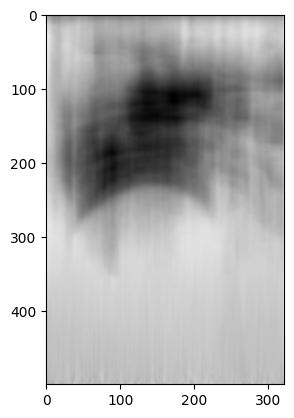

In [7]:
shadow_image = shadow_value(img, sigma=50)
shadow_image = shadow_image / np.max(shadow_image)
shadow_image = 1 - shadow_image
plt.imshow(shadow_image, cmap='gray')

## Log-Gabor filter

In [99]:
number_scales = 5          # scale resolution
number_orientations = 8    # orientation resolution
N = 128                    # image dimensions
def getFilter(f_0, theta_0):
    # filter configuration
    scale_bandwidth =  0.996 * math.sqrt(2/3)
    angle_bandwidth =  0.996 * (1/math.sqrt(2)) * (np.pi/number_orientations)

    # x,y grid
    extent = np.arange(-N/2, N/2 + N%2)
    x, y = np.meshgrid(extent,extent)

    mid = int(N/2)
    ## orientation component ##
    theta = np.arctan2(y,x)
    center_angle = ((np.pi/number_orientations) * theta_0) if (f_0 % 2) \
                else ((np.pi/number_orientations) * (theta_0+0.5))

    # calculate (theta-center_theta), we calculate cos(theta-center_theta) 
    # and sin(theta-center_theta) then use atan to get the required value,
    # this way we can eliminate the angular distance wrap around problem
    costheta = np.cos(theta)
    sintheta = np.sin(theta)
    ds = sintheta * math.cos(center_angle) - costheta * math.sin(center_angle)    
    dc = costheta * math.cos(center_angle) + sintheta * math.sin(center_angle)  
    dtheta = np.arctan2(ds,dc)

    orientation_component =  np.exp(-0.5 * (dtheta/angle_bandwidth)**2)

    ## frequency componenet ##
    # go to polar space
    raw = np.sqrt(x**2+y**2)
    # set origin to 1 as in the log space zero is not defined
    raw[mid,mid] = 1
    # go to log space
    raw = np.log2(raw)

    center_scale = math.log2(N) - f_0
    draw = raw-center_scale
    frequency_component = np.exp(-0.5 * (draw/ scale_bandwidth)**2)

    # reset origin to zero (not needed as it is already 0?)
    frequency_component[mid,mid] = 0

    return frequency_component * orientation_component, frequency_component, orientation_component

def get_filter_bank(img_size, number_scales, number_orientations):
    filter_bank = []
    
    # Loop over orientations and scales
    for o in range(number_orientations):
        for s in range(number_scales):
            
            filter_bank.append(getFilter(s+1, o))
            
    return filter_bank
            

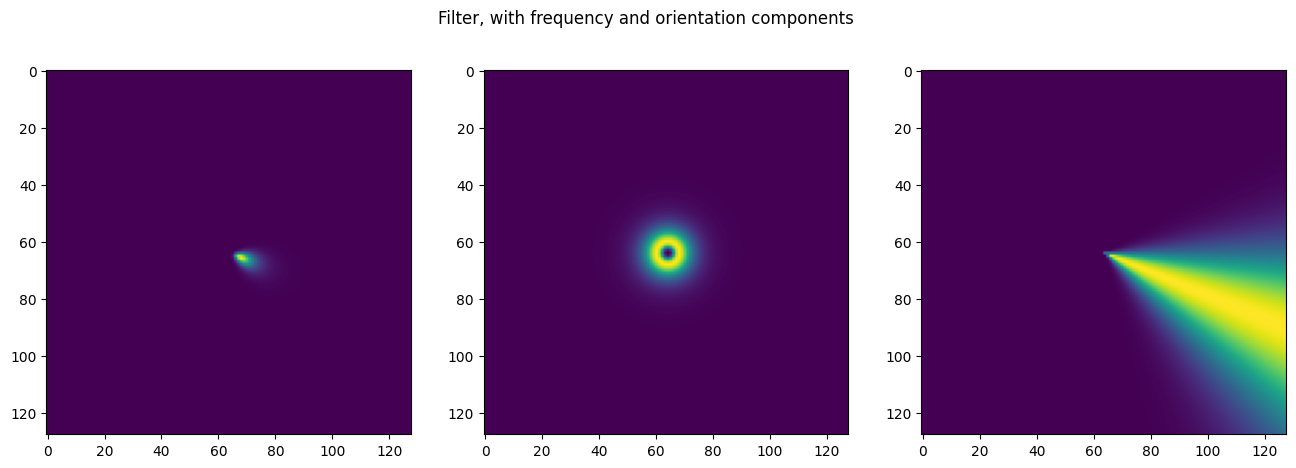

In [100]:
filter, freq_filter, orient_filter = getFilter(5, 1)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle('Filter, with frequency and orientation components')
ax1.imshow(filter)
ax2.imshow(freq_filter)
ax3.imshow(orient_filter)
plt.show()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


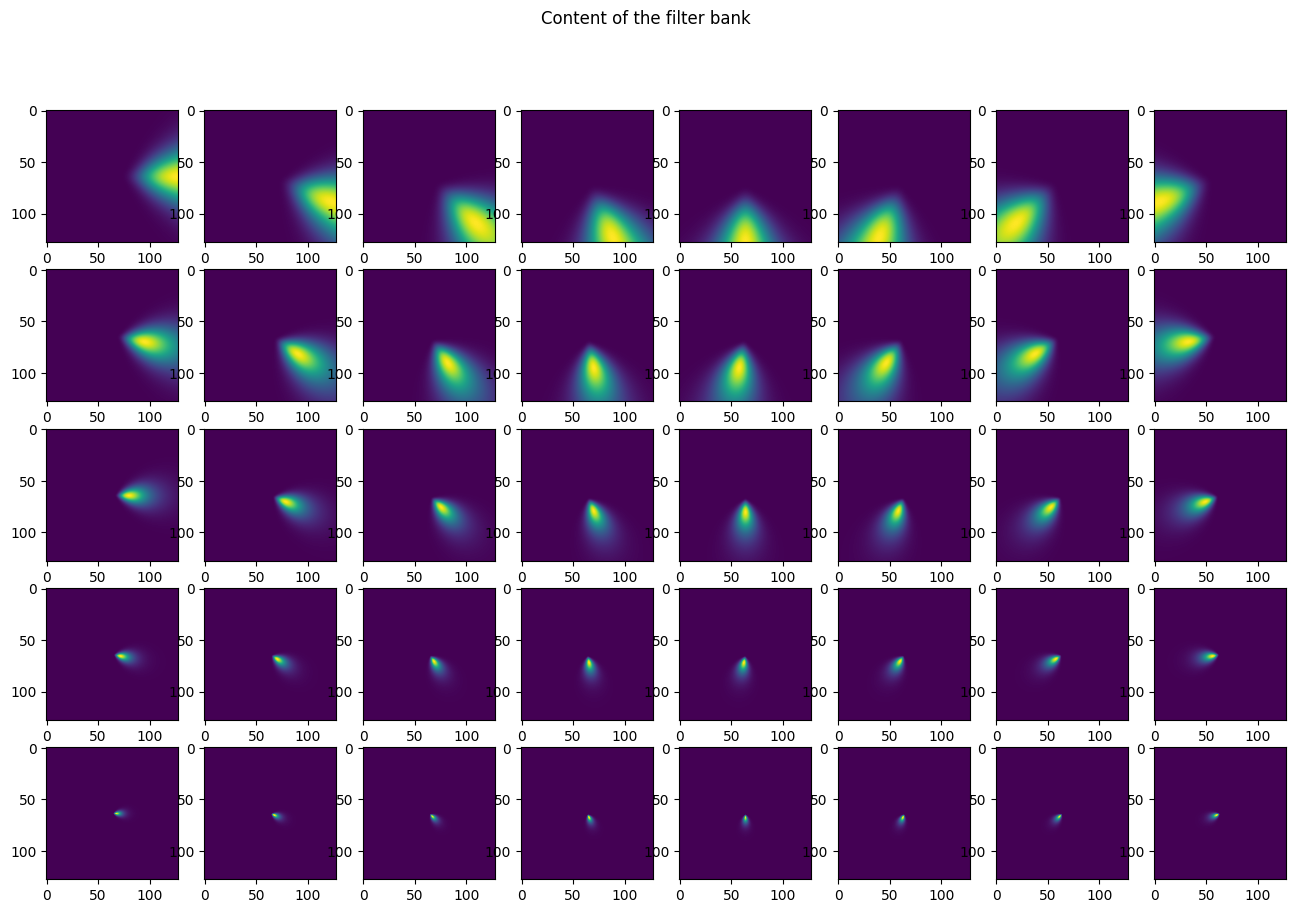

In [101]:
filters = get_filter_bank(N, number_scales, number_orientations)

plt_img_size = 2
fig, axes = plt.subplots(number_scales, number_orientations, figsize=(number_orientations*plt_img_size, number_scales*plt_img_size))
fig.suptitle('Content of the filter bank')
for no in range(number_orientations):
    for ns in range(number_scales):
        axes[ns, no].imshow(filters[no*number_scales+ns][0])
        print(no*number_scales+ns)
plt.show()

In [102]:
def log_gabor_filter_bank(image_size, num_orientations=8, num_scales=5, min_frequency=0.1, max_frequency=0.4):
    # filter configuration
    scale_bandwidth =  0.996 * math.sqrt(2/3)
    angle_bandwidth =  0.996 * (1/math.sqrt(2)) * (np.pi/num_orientations)
    
    # Create a meshgrid for the frequency and orientation values
    image_width, image_length = image_size.shape()
    x, y = np.meshgrid(np.linspace(-image_width/2, image_width/2, image_width),
                       np.linspace(-image_length/2, image_length/2, image_length))
    radius = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    # theta[theta<0] += np.pi
    
    # Initialize filter bank
    filter_bank = []
    
    # Loop over orientations and scales
    for o in range(num_orientations):
        orientation = o*np.pi/num_orientations
        for s in range(num_scales):
            
            
            
            frequency = min_frequency*np.exp(s*np.log(max_frequency/min_frequency)/(num_scales-1))
            
            # Compute Gabor filter
            wavelength = 1/frequency
            phase = 0.5
            bandwidth = 1
            ellipticity = 0.5
            
            gamma = np.sqrt(2*np.log(2))/np.pi * (bandwidth + 0.5)/(bandwidth - 0.5)
            sigma_x = wavelength*gamma
            sigma_y = wavelength*gamma/ellipticity
            
            x_theta = x*np.cos(orientation) + y*np.sin(orientation)
            y_theta = -x*np.sin(orientation) + y*np.cos(orientation)
            
            gb_real = np.exp(-0.5*(x_theta**2/sigma_x**2 + y_theta**2/sigma_y**2)) * np.cos(2*np.pi*frequency*x_theta + phase)
            gb_imag = np.exp(-0.5*(x_theta**2/sigma_x**2 + y_theta**2/sigma_y**2)) * np.sin(2*np.pi*frequency*x_theta + phase)
            
            # Apply log-Gabor filter
            sigma_f = np.sqrt(np.log(2)/2) * (np.log(max_frequency) - np.log(min_frequency)) / (num_scales-1)
            filter = np.exp(-0.5*(np.log(radius/frequency)**2/sigma_f**2))
            filter *= gb_real + gb_imag
            
            # Normalize filter
            filter = filter - np.mean(filter)
            filter = filter / np.sum(np.abs(filter))
            
            # Append filter to filter bank
            filter_bank.append(filter)
    
    return filter_bank

img_size = (128, 128)
log_gabor_filters = log_gabor_filter_bank(img_size)
plt.imshow(log_gabor_filters[15])

AttributeError: 'tuple' object has no attribute 'shape'

## Integrated backscattering

$\operatorname{IBS}(a, b)= \displaystyle\sum_{i=1}^{b} I^2(a, i)$

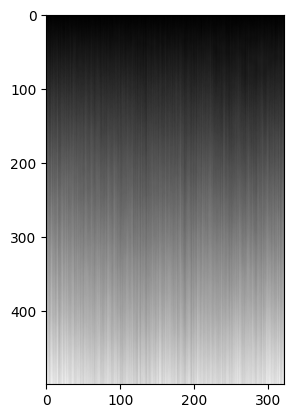

In [ ]:
def IBS(img):
    squared_image = np.square(img)
    
    # Cumulative sum of each row
    ibs = np.cumsum(squared_image, axis=0)
        
    # Normalize between 0 and 1
    ibs = ibs / np.max(ibs)
    
    return ibs

ibs = IBS(img)
plt.imshow(ibs, cmap='gray')

## Final probability map

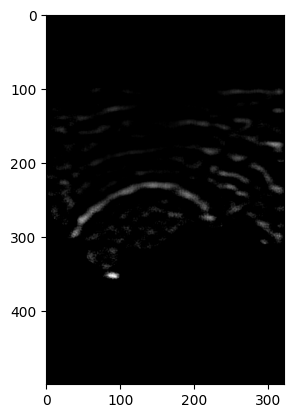

In [ ]:
thresh = thresh.astype(np.float64)
prob_map = laplacian * thresh * shadow_image * ibs
prob_map /= np.max(prob_map)

# Trim the values too low
threshold = 0.05

prob_map = np.clip(prob_map, threshold, 1)


plt.imshow(prob_map, cmap='gray')

# Bone Localization Optimization

$E_{\text {int }}(i, j)=\left\{\begin{array}{lc}\alpha\left\|\frac{d S e g}{d s}\right\|^2+\beta\left\|\frac{d^2 \operatorname{Seg}}{d s^2}\right\|^2+\gamma & \text { Bone region } \\ \text { JumpCost } & \text { Jump region }\\ \alpha D_1^2+\beta D_2^2 & \text { Boneless region }\end{array}\right.$